
##Pre-requisitos

In [1]:
# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug 
!pip install tensorflow-io

     |████████████████████████████████| 35.5MB 108kB/s 
     |████████████████████████████████| 21.8MB 1.5MB/s 


In [2]:
import os 
import sys

import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob 
import gc
import tensorflow as tf
import tensorflow_io as tfio

import csv
from skimage import io
from skimage import measure
from skimage.transform import resize

from tensorflow import keras

from matplotlib import pyplot as plt
import matplotlib.patches as patches

from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, rmsprop, SGD

import textwrap
from xml.sax.saxutils import escape

from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Dataset

Dado que el dataset ya esta descargado de la competencia de Kaggle, solo se debe configurar la conexión con Drive para tener acceso.

In [4]:
#CONEXIÓN DRIVE 
from google.colab import drive

drive.mount('/content/drive')

# Root directory of the project 
ROOT_DIR = os.path.abspath('/content/RN__TP_Final')

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, 'logs')

if not os.path.exists(ROOT_DIR):
    os.makedirs(ROOT_DIR)
os.chdir(ROOT_DIR)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


A lo largo del código, se accede a los archivos guardados en Google Drive con estas variables

In [5]:
#Build directions
main_dir = '/content/drive/My Drive/Final_redes/RN__TP_Final'
train_dicom_dir = os.path.join(main_dir, 'stage_2_train_images')
test_dicom_dir = os.path.join(main_dir, 'stage_2_test_images')
train_labels_dir = os.path.join(main_dir, 'stage_2_train_labels.csv')

Armado de las anotaciones como dataframe de pandas para poder utilizarlas durante el procesamiento

In [6]:
#Labels are not longer a class: given a patient id, one or more rows with bounding box coordinates.
#If no bounding box, row with id but empty coordinates
train_labels = pd.read_csv(os.path.join(main_dir, 'stage_2_train_labels.csv'))
train_labels.head(5)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


Armado del dataframe *df* que se utiliza a lo largo del código. Hace un innerjoin del dataframe con las anotaciones (train_labels) y el dataframe con la información de a qué clase original del dataset de NIH pertenecía. Recordar que aquellos registros sin opacidades pulmonares podían ser *Normal* (pacientes sanos) o *No Lung Opacity / Not Normal*. El innerjoin agrega entonces el nombre de su clase, más allá del discriminador de Target que solo discrimina con o sin opacidades.

In [7]:
detailed_class_info = pd.read_csv(os.path.join(main_dir, 'stage_2_detailed_class_info.csv'))
train_labels = pd.read_csv(train_labels_dir) 

df = pd.merge(left = detailed_class_info, right = train_labels, how = 'left', on = 'patientId')

del detailed_class_info, train_labels
gc.collect()

df = df.drop_duplicates()
df.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30227 entries, 0 to 37626
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   class      30227 non-null  object 
 2   x          9555 non-null   float64
 3   y          9555 non-null   float64
 4   width      9555 non-null   float64
 5   height     9555 non-null   float64
 6   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 1.8+ MB


#Materiales y métodos

Se optó por implementar una solución mediante el uso del framework de código abierto *Darknet* escrito en C. Fue desarrollado entre el 2013 y el 2016 por Joseph Redmon, alias *pjreddie* [1]. Sin embargo, para entrenar la red se parte de los pesos de *pjreddie*. Este tipo de implementación con *kriyeng*, utilizando los pesos iniciales de *pjreddie* se ha visto en la gran mayoría de casos investigados que utilizan Yolo v3 [2].  

A la hora de elegir un modelo para realizar la detección de opacidades, debe tenerse en cuenta que dicha detección debería realizarse en tiempo real. Esto es porque se la conceptualiza como una asistencia al diagnóstico in-situ. Para poder cumplir con este objetivo, se escogió el sistema YOLO (you only look once), el cual es una herramienta de detección de objetos en tiempo real muy eficiente en cuanto a la velocidad de procesamiento. 

YOLO es una arquitectura que se basa en la detección de objetos como un problema de regresión a cuadros delimitadores espacialmente separados y probabilidades de clase asociadas directamente de imágenes completas en una evaluación. Dado que todo el sistema de detección es una red única, se puede optimizar de extremo a extremo directamente en el rendimiento de detección. YOLO procesa imágenes en tiempo real a 45 cuadros por segundo. Si bien YOLO no es el mejor detector en cuanto a resultados de accuracies en comparación con los sistemas de detección, es menos probable que prediga falsos positivos y tiene una velocidad superior. A su vez, YOLO aprende representaciones muy generales de objetos. Una sola red convolucional predice simultáneamente múltiples cuadros delimitadores y probabilidades de clase para esos cuadros. YOLO entrena en imágenes completas y optimiza directamente el rendimiento de detección \cite{kaggle2_}. La estructura de la red se presenta en la figura \ref{fig:YOLO}. A diferencia de las versiones anteriores, YOLO v3 usa una variante de Darknet, que originalmente tiene una red de 53 capas entrenada en Imagenet. Para la tarea de detección, se apilan 53 capas más, lo que da una arquitectura subyacente totalmente convolucional de 106 capas para YOLO v3. 

La arquitectura de YoloV3 se basa en conexiones de salto residuales y muestreo ascendente. La característica más destacada de v3 es que realiza detecciones en tres escalas diferentes. YOLO es una red totalmente convolucional y su salida eventual se genera aplicando un núcleo 1 x 1 en un mapa de características. En YOLO v3, la detección se realiza mediante la aplicación de núcleos de detección 1 x 1 en mapas de características de tres tamaños diferentes (reduciendo el muestreo de las dimensiones de la imagen de entrada en 32, 16 y 8 respectivamente) en tres lugares diferentes de la red. 

La salida es un mapa de características. Gracias a las convoluciones 1 x 1, el tamaño del mapa de predicción es exactamente el tamaño del mapa de características antes que él.  En YOLO v3, la forma en que interpreta este mapa de predicción es que cada celda puede predecir un número fijo de cuadros delimitadores. En cuanto a la profundidad, las entradas en el mapa de características son (B x (5 + C)) en el mapa de características, donde B representa el número de cuadros delimitadores que cada celda puede predecir. Según el documento, cada uno de estos cuadros delimitadores B puede especializarse en detectar un cierto tipo de objeto. Cada uno de los cuadros delimitadores tiene 5 + C atributos, que describen las coordenadas del centro, las dimensiones, la puntuación de objetividad y las confidencias de clase C para cada cuadro delimitador. YOLO v3 predice 3 cuadros delimitadores para cada celda.





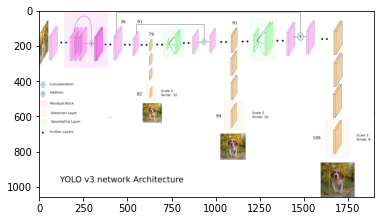

In [ ]:
img_dir = '/content/drive/My Drive/Final_redes/yoloV3Arq.png'

img = np.array(Image.open(img_dir))
plt.figure()
plt.imshow(img)

Describiendo la arquitectura en si, la primera detección la realiza la capa 82. Para las primeras 81 capas, se tiene un paso de 32. Es decir, con una imagen de 416 x 416, el mapa de características resultante sería de tamaño 13 x 13. En la capa 82 se hace una detección usando el núcleo de detección 1 x 1, lo que nos da un mapa de características de detección de 13 x 13 x 255.
Luego, el mapa de características de la capa 79 se somete a unas pocas capas convolucionales antes de ser muestreado en 2x a dimensiones de 26 x 26. Este mapa de características se concatena en profundidad con el mapa de características de la capa 61, tal como se muestra en la imagen presentada anteriormente. Luego, los mapas de características combinados se someten nuevamente a unas pocas capas convolucionales 1 x 1 para fusionar las características de la capa anterior (la 61). La segunda detección es realizada por la capa 94, produciendo un mapa de características de detección de 26 x 26 x 255.
Se sigue de nuevo un procedimiento similar, donde el mapa de características de la capa 91 está sujeto a pocas capas convolucionales antes de ser concatenado en profundidad con un mapa de características de la capa 36. Como antes, siguen unas pocas capas convolucionales 1 x 1 para fusionar la información de la capa anterior (la 36). Hacemos el final del 3 en la capa 106, obteniendo un mapa de características de tamaño 52 x 52 x 255.

Un detalle importante a mencionar es la capacidad de Yolo v3 frente a v2 de detectar objetos pequeños. Las capas muestreadas concatenadas con las capas anteriores ayudan a preservar las características de grano fino que ayudan a detectar objetos pequeños. De esta manera, la capa 13 x 13 es responsable de detectar objetos grandes, mientras que la capa 52 x 52 detecta los objetos más pequeños, mientras que la capa 26 x 26 detecta objetos medianos. 



Es posible correr una red neuronal con Darknet en la plataforma de Google Colaboratory, lo cual significó una gran ventaja dado que este trabajo fue realizado en equipo y a distancia.

En esta notebook se realiza la conversión de los archivos en formato DICOM (los cuales nos descargamos en la notebook llamada Redes-NeuronalesTpFinal, a formato .jpg
Esto es necesario para poder obtener las imagenes y así realizar los entrenamientos correspondientes. A su vez, se configuran los archivos necesarios para poder entrenar la arquitectura Darknet.

##Métricas de evaluación

El diseño de YOLO permite un entrenamiento de extremo a extremo y velocidades en tiempo real mientras mantiene una alta precisión promedio. El sistema divide la imagen de entrada en una cuadrícula S x  S. Si el centro de un objeto cae en una celda de cuadrícula, esa celda de cuadrícula es responsable de detectar ese objeto. Cada celda de la cuadrícula predice cuadros delimitadores B y puntajes de confianza para esos cuadros. Estos puntajes de confianza reflejan cuán seguro es el modelo de que el cuadro contiene un objeto y también qué tan preciso cree que es el cuadro que predice. Formalmente definimos la confianza como Pr (Objeto)x IOUtruth pred. Si no existe ningún objeto en esa celda, los puntajes de confianza deben ser cero. De lo contrario, queremos que la puntuación de confianza sea igual a la intersección sobre la unión (IOU) entre el cuadro predicho y la verdad básica. Cada cuadro delimitador consta de 5 predicciones: x, y, w, h y confianza. Las coordenadas (x, y) representan el centro del cuadro en relación con los límites de la celda de la cuadrícula. El ancho y la altura se predicen en relación con toda la imagen. Finalmente, la predicción de confianza representa el IOU entre el cuadro predicho y cualquier cuadro de verdad fundamental. Cada celda de la cuadrícula también predice probabilidades de clase condicional C, Pr (Classi | Object). Estas probabilidades están condicionadas por la celda de la cuadrícula que contiene un objeto. Solo predecimos un conjunto de probabilidades de clase por celda de cuadrícula, independientemente del número de casillas B. En el momento de la prueba, multiplicamos las probabilidades de clase condicionales y las predicciones de confianza de casillas individuales, 

Pr(Class_{i} | Object)*Pr(Object)*IOU{truth pred} = Pr(Class_{i})*IOU{truth pred}

lo que nos da puntajes de confianza específicos de clase para cada casilla. Estos puntajes codifican tanto la probabilidad de que esa clase aparezca en el cuadro como qué tan bien se ajusta el cuadro predicho al objeto

##Función de costo

La función de costo que se piensa utilizar es la implementada por la estructura de YOLO. Observando los últimos tres términos, el primero penaliza la predicción del puntaje de objetividad para los cuadros delimitadores responsables de predecir objetos (los puntajes para estos deberían ser idealmente 1), el segundo para los cuadros delimitadores que no tienen objetos (los puntajes deberían ser idealmente cero), y el el último penaliza la predicción de clase para el cuadro delimitador que predice los objetos.
Los últimos tres términos en YOLO v2 son los errores al cuadrado, mientras que en YOLO v3, han sido reemplazados por términos de error de entropía cruzada. En otras palabras, la confianza del objeto y las predicciones de clase en YOLO v3 ahora se predicen a través de la regresión logística.
https://blog.paperspace.com/how-to-implement-a-yolo-object-detector-in-pytorch/

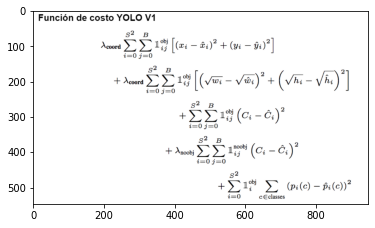

In [ ]:
img_dir = '/content/drive/My Drive/Final_redes/funcion_de_costo (1).PNG'

img = np.array(Image.open(img_dir))
plt.figure()
plt.imshow(img)

# Mass Jpeg Conversion

Se utilizó IRFAN View.

IrfanView es un software gratuito que permite la conversión de grandes cantidades de archivos. En particular, es reconocido por ser un programa de alta calidad de conversión de archivos tipo DICOM a JPG. Una de las herramientas que posee utilizada en este trabajo es la capacidad de hacer un reshape de las imagenes JPG. Por lo tanto, esto nos permitió quedarnos con un archivo de nuestro dataset original de imágenes 1024x1024 y otro resampleado de 256x256 para el posterior entrenamiento de la red. De esta manera, se realizan dos entrenamientos distintos, con los distintos tamaños de imagen.

El hecho de que permite subir una gran cantidad de archivos fue crucial dado que debíamos convertir más de 26 mil imágenes de entrenamiento y 3 mil imágenes más de testeo. Otros softwares requerirían que se suban de a una o solo grupos pequeños de imágenes. La conversión también podría haberse realizado con pydicom pero era una alternativa lenta.

# Armado de las anotaciones
En el problema en cuestión, se tiene una única clase a detectar: opacidad pulmonar. Las imágenes normales o anormales que no corresponden a una opacidad pulmonar son consideradas como imágenes con ausencia de objetos a detectar. Darknet enumera las clases para indicar su detección, por lo cual en este caso se tiene una única clase bajo el índice 0.

Las anotaciones provistas por RSNA están en formato .csv bajo las leyendas detalladas anteriormente con uno o más registros por imagen, identificadas por el id del paciente. Para su manipulación, se trabajó con dataframes de Pandas.

Para poder entrenar la red en Darknet, se necesita que cada una de las imágenes tenga un único archivo correspondiente a las anotaciones de esa imagen. Este archivo debe ser de tipo texto (.txt) con el nombre del id del paciente. Esto es crucial para el binding que realiza Darknet de la anotación con la imagen. Por cada objeto presente debe haber una línea con el formato indicado en la ecuación *anotaciones*, donde:  

anotaciones:
<n_{class}>  <x_{center}>  <y_{center}>  <width> <height>

- *n_class*: corresponde al número de clase
- *x_center* y *y_center*: son números decimales que indican la posición del centro de la bounding box con respecto a las dimensiones de la imagen, es decir normalizadas y 
- *width* y *height* son números decimales que representan el ancho y el alto de la bounding box, también normalizados.

Cabe destacar que estos cuatro números varían del 0 al 1. Las imágenes que no poseen opacidad pulmonar también tienen su archivo de anotaciones, solo que vacío. Fue necesario iterar en torno a las anotaciones provistas por RSNA para poder construir las nuevas anotaciones.

Para el armado de las anotaciones como las necesita Darknet, se crearon por un lado las anotaciones de las imágenes con opacidades pulmonares y por el otro lado de las imágenes sin opacidades.

## Imágenes con opacidades
Primero se filtra el dataframe *df* para conservar únicamente las que tengan Target = 1.

In [ ]:
df_with_op = df[df['Target']==1].copy()
df_with_op['class'] = '0'
df_with_op['x_center'] = (df_with_op['x']+df_with_op['width'])/2/1024
df_with_op['y_center'] = (df_with_op['y']+df_with_op['height'])/2/1024
df_with_op['width'] = df_with_op['width']/1024
df_with_op['height'] = df_with_op['height']/1024
df_with_op.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9555 entries, 4 to 37626
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  9555 non-null   object 
 1   class      9555 non-null   object 
 2   x          9555 non-null   float64
 3   y          9555 non-null   float64
 4   width      9555 non-null   float64
 5   height     9555 non-null   float64
 6   Target     9555 non-null   int64  
 7   x_center   9555 non-null   float64
 8   y_center   9555 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 746.5+ KB


En paralelo se arma un dataframe que solo conserva los ids de los pacientes con opacidades. Para esto, se toma solo la columna de patientId del dataframe anterior y se descartan los duplicados ya que puede haber más de una opacidad por paciente y por ende, más de un registro con el mismo patientId.

In [ ]:
df_patients = pd.DataFrame(df_with_op['patientId'].drop_duplicates())

df_patients

,patientId
4,00436515-870c-4b36-a041-de91049b9ab4
10,00704310-78a8-4b38-8475-49f4573b2dbb
18,00aecb01-a116-45a2-956c-08d2fa55433f
22,00c0b293-48e7-4e16-ac76-9269ba535a62
27,00f08de1-517e-4652-a04f-d1dc9ee48593
...,...
37600,c18d1138-ba74-4af5-af21-bdd4d2c96bb5
37608,c1cddf32-b957-4753-acaa-472ab1447e86
37615,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2
37619,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8


Se itera en torno al último dataframe generado y se crea el archivo de anotaciones. Para esto, en cada iteración se filtra el dataframe *df_with_op* con el id del paciente de la iteración, se descarta las columnas correspondientes a patientId y Target, conservando únicamente las que deben incluirse en el .txt y guardandolo como un dataframe *opacities*. Por último, se crea un archivo cuyo nombre es el id del paciente y dentro tiene cada registro de las *opacities* separados por un espacio. El archivo se guarda en la carpeta de "content/RN__TP_FINAL" de la notebook. Se creó esta carpeta intermedia para poder guardar archivos ahí y luego poder moverlos en bloque.

In [ ]:
for i_p, row_p in df_patients.iterrows():
  patientId = row_p[0]
  opacities = df_with_op[df_with_op['patientId']==patientId].dropna()[['class','x_center', 'y_center', 'width', 'height']].copy()
  np.savetxt(patientId+".txt", opacities, fmt='%s')

Este comando mueve los archivos de esta carpeta a la carpeta de Google Drive donde se encuentran las imágenes. Cabe destacar que este código se utilizó múltiples veces ya que se tenían múltiples modelos y algunos tenían su propia copia del dataset.

In [ ]:
!mv /content/RN__TP_Final/* '/content/drive/My Drive/Final_redes/Notebooks/DarkNet-flipped/data/obj'

## Imágenes sin opacidad
Este código es semejante al anterior.

In [ ]:
df_without_op = df[df['Target']==0].copy()
df_without_op.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20672 entries, 0 to 37624
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  20672 non-null  object 
 1   class      20672 non-null  object 
 2   x          0 non-null      float64
 3   y          0 non-null      float64
 4   width      0 non-null      float64
 5   height     0 non-null      float64
 6   Target     20672 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 1.3+ MB


In [ ]:
df_patients_wo = pd.DataFrame(df_without_op['patientId'].drop_duplicates())

df_patients_wo

,patientId
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd
2,00322d4d-1c29-4943-afc9-b6754be640eb
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5
8,00569f44-917d-4c86-a842-81832af98c30
...,...
37612,c1cf3255-d734-4980-bfe0-967902ad7ed9
37613,c1e228e4-b7b4-432b-a735-36c48fdb806f
37614,c1e3eb82-c55a-471f-a57f-fe1a823469da
37623,c1edf42b-5958-47ff-a1e7-4f23d99583ba


Por cada iteración, únicamente se crea un archivo vacío de tipo texto con el id del paciente en el nombre.

In [ ]:
for i_p, row_p in df_patients_wo.iterrows():
  patientId = row_p[0]
  open(patientId+".txt", 'a').close()

Los archivos se mueven en bloque a la misma carpeta.

In [ ]:
!mv /content/RN__TP_Final/* '/content/drive/My Drive/Final_redes/Notebooks/DarkNet-flipped/data/obj'

## Darkflow
Encontramos el trabajo de Jake Huneycutt [3] donde utiliza el framework de Darkflow para resolver este problema en lugar de Darknet. Darkflow es otra implementación de YOLO solo que utiliza YOLO v2 en lugar de YOLO v3 y es menos popular. Intentamos utilizar Darkflow cuando no estábamos seguras si íbamos a poder montar la arquitectura de Darknet ya que estábamos teniendo problemas a la hora de empezar a correr la red. Si bien Darkflow es una peor alternativa en cuanto a a la *performance*, fue considerado como un plan alternativo en caso de no poder utilizar Darknet. Por lo tanto, se prepararon los archivos correspondientes para implementarla. Las secciones en esta notebook de *Set up templates* y *XML generator* representan el intento de implementar Darkflow. Durante dos días, trabajamos ambas alternativas en paralelo hasta que conseguimos compilar la primera red de Darknet y por lo tanto no fue necesario usar Darkflow.

### Anotaciones
El dataframe se arma de forma semejante al de Darknet, solo que con más columnas. Estas serán necesarias para el armado de los archivos por medio de los templates que se presentan más adelante.

In [ ]:
df_patients = pd.DataFrame(df_with_op['patientId'].drop_duplicates())
df_patients['x_min1'] = np.nan
df_patients['y_min1'] = np.nan
df_patients['x_max1'] = np.nan
df_patients['y_max1'] = np.nan
df_patients['x_min2'] = np.nan
df_patients['y_min2'] = np.nan
df_patients['x_max2'] = np.nan
df_patients['y_max2'] = np.nan
df_patients['x_min3'] = np.nan
df_patients['y_min3'] = np.nan
df_patients['x_max3'] = np.nan
df_patients['y_max3'] = np.nan
df_patients['x_min4'] = np.nan
df_patients['y_min4'] = np.nan
df_patients['x_max4'] = np.nan
df_patients['y_max4'] = np.nan

In [ ]:
for i_p, row_p in df_patients.iterrows():
  patientId = row_p[0]
  opacities = df_with_op[df_with_op['patientId']==patientId]
  i_o = 1
  for index, row_o in opacities.iterrows():
    row_o[2:6] = [int(float(i)) for i in row_o[2:6]]
    xminlabel = 'x_min'+str(i_o)
    yminlabel = 'y_min'+str(i_o)
    xmaxlabel = 'x_max'+str(i_o)
    ymaxlabel = 'y_max'+str(i_o)
    i_o=i_o+1    
    df_patients.loc[i_p, [xminlabel,yminlabel,xmaxlabel,ymaxlabel]] = [row_o[2],row_o[3],row_o[2] + row_o[4],row_o[3] + row_o[5]]

Se guarda el archivo como un csv

In [ ]:
df_patients.to_csv('annotations.csv', columns=['patientId','x_min1', 'y_min1','x_max1', 'y_max1','x_min2', 'y_min2','x_max2', 'y_max2','x_min3', 'y_min3','x_max3', 'y_max3','x_min4', 'y_min4','x_max4', 'y_max4'], sep='\t',index = False)

### Armado de los dataframes
Fue necesario armar un dataframe para cada uno de los templates. Cada dataframe tenía registros con el número de opacidades indicado en el título. Para filtrar, dado que se iban guardando en orden, bastó con filtrar según a partir de qué columna tenían valores nulos.

In [ ]:
# create df for entries with 1 bounding box
df_1box = df_patients[df_patients.x_min2.isnull()]
df_1box = df_1box.drop(['x_min2', 'y_min2',
       'x_max2', 'y_max2', 'x_min3', 'y_min3', 'x_max3', 'y_max3', 'x_min4',
       'y_min4', 'x_max4', 'y_max4'], axis=1)
df_1box.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2614 entries, 32 to 37597
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  2614 non-null   object 
 1   x_min1     2614 non-null   float64
 2   y_min1     2614 non-null   float64
 3   x_max1     2614 non-null   float64
 4   y_max1     2614 non-null   float64
dtypes: float64(4), object(1)
memory usage: 122.5+ KB


In [ ]:
# create df for entries with 2 bounding boxes
df_2box = df_patients[df_patients.x_min3.isnull() & df_patients.x_min2.notnull()]
df_2box = df_2box.drop(['x_min3', 'y_min3', 'x_max3', 'y_max3', 'x_min4',
       'y_min4', 'x_max4', 'y_max4'], axis=1)
df_2box.loc[:, 'x_min1':] = df_2box.loc[:, 'x_min1':].astype(int)
df_2box.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3266 entries, 4 to 37625
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  3266 non-null   object
 1   x_min1     3266 non-null   int64 
 2   y_min1     3266 non-null   int64 
 3   x_max1     3266 non-null   int64 
 4   y_max1     3266 non-null   int64 
 5   x_min2     3266 non-null   int64 
 6   y_min2     3266 non-null   int64 
 7   x_max2     3266 non-null   int64 
 8   y_max2     3266 non-null   int64 
dtypes: int64(8), object(1)
memory usage: 255.2+ KB
None


In [ ]:
# create df for entries with 3 bounding boxes
df_3box = df_patients[df_patients.x_min4.isnull() & df_patients.x_min3.notnull() & df_patients.x_min3.notnull()]
df_3box = df_3box.drop(['x_min4',
       'y_min4', 'x_max4', 'y_max4'], axis=1)
df_3box.loc[:, 'x_min1':] = df_3box.loc[:, 'x_min1':].astype(int)
df_3box.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119 entries, 176 to 37425
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  119 non-null    object
 1   x_min1     119 non-null    int64 
 2   y_min1     119 non-null    int64 
 3   x_max1     119 non-null    int64 
 4   y_max1     119 non-null    int64 
 5   x_min2     119 non-null    int64 
 6   y_min2     119 non-null    int64 
 7   x_max2     119 non-null    int64 
 8   y_max2     119 non-null    int64 
 9   x_min3     119 non-null    int64 
 10  y_min3     119 non-null    int64 
 11  x_max3     119 non-null    int64 
 12  y_max3     119 non-null    int64 
dtypes: int64(12), object(1)
memory usage: 13.0+ KB


In [ ]:
# create df for entries with 3 bounding boxes
df_4box = df_patients[df_patients.x_min4.notnull()]
df_4box.loc[:, 'x_min1':] = df_4box.loc[:, 'x_min1':].astype(int)
df_4box.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13 entries, 1119 to 36654
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  13 non-null     object
 1   x_min1     13 non-null     int64 
 2   y_min1     13 non-null     int64 
 3   x_max1     13 non-null     int64 
 4   y_max1     13 non-null     int64 
 5   x_min2     13 non-null     int64 
 6   y_min2     13 non-null     int64 
 7   x_max2     13 non-null     int64 
 8   y_max2     13 non-null     int64 
 9   x_min3     13 non-null     int64 
 10  y_min3     13 non-null     int64 
 11  x_max3     13 non-null     int64 
 12  y_max3     13 non-null     int64 
 13  x_min4     13 non-null     int64 
 14  y_min4     13 non-null     int64 
 15  x_max4     13 non-null     int64 
 16  y_max4     13 non-null     int64 
dtypes: int64(16), object(1)
memory usage: 1.8+ KB


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


### Templates



In [ ]:
template_1box = textwrap.dedent("""\
<annotation>
    <folder>VOC2007</folder>
    <filename>{filename}.jpg</filename>
    <source>
        <database>The VOC2007 Database</database>
        <annotation>PASCAL VOC2007</annotation>
        <image>flickr</image>
        <flickrid>336426776</flickrid>
    </source>
    <owner>
        <flickrid>Elder Timothy Chaves</flickrid>
        <name>Tim Chaves</name>
    </owner>
    <size>
        <width>256</width>
        <height>256</height>
        <depth>1</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>opacity</name>
        <pose>unknown</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <bndbox>
            <xmin>{xmin1}</xmin>
            <ymin>{ymin1}</ymin>
            <xmax>{xmax1}</xmax>
            <ymax>{ymax1}</ymax>
        </bndbox>
    </object>
</annotation>""")

In [ ]:
template_2box = textwrap.dedent("""\
<annotation>
    <folder>VOC2007</folder>
    <filename>{filename}.jpg</filename>
    <source>
        <database>The VOC2007 Database</database>
        <annotation>PASCAL VOC2007</annotation>
        <image>flickr</image>
        <flickrid>336426776</flickrid>
    </source>
    <owner>
        <flickrid>Elder Timothy Chaves</flickrid>
        <name>Tim Chaves</name>
    </owner>
    <size>
        <width>256</width>
        <height>256</height>
        <depth>1</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>opacity</name>
        <pose>unknown</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <bndbox>
            <xmin>{xmin1}</xmin>
            <ymin>{ymin1}</ymin>
            <xmax>{xmax1}</xmax>
            <ymax>{ymax1}</ymax>
        </bndbox>
    </object>
    <object>
        <name>opacity</name>
        <pose>unknown</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <bndbox>
            <xmin>{xmin2}</xmin>
            <ymin>{ymin2}</ymin>
            <xmax>{xmax2}</xmax>
            <ymax>{ymax2}</ymax>
        </bndbox>
    </object>
</annotation>""")

In [ ]:
template_3box = textwrap.dedent("""\
<annotation>
    <folder>VOC2007</folder>
    <filename>{filename}.jpg</filename>
    <source>
        <database>The VOC2007 Database</database>
        <annotation>PASCAL VOC2007</annotation>
        <image>flickr</image>
        <flickrid>336426776</flickrid>
    </source>
    <owner>
        <flickrid>Elder Timothy Chaves</flickrid>
        <name>Tim Chaves</name>
    </owner>
    <size>
        <width>256</width>
        <height>256</height>
        <depth>1</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>opacity</name>
        <pose>unknown</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <bndbox>
            <xmin>{xmin1}</xmin>
            <ymin>{ymin1}</ymin>
            <xmax>{xmax1}</xmax>
            <ymax>{ymax1}</ymax>
        </bndbox>
    </object>
    <object>
        <name>opacity</name>
        <pose>unknown</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <bndbox>
            <xmin>{xmin2}</xmin>
            <ymin>{ymin2}</ymin>
            <xmax>{xmax2}</xmax>
            <ymax>{ymax2}</ymax>
        </bndbox>
    </object>
    <object>
        <name>opacity</name>
        <pose>unknown</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <bndbox>
            <xmin>{xmin3}</xmin>
            <ymin>{ymin3}</ymin>
            <xmax>{xmax3}</xmax>
            <ymax>{ymax3}</ymax>
        </bndbox>
    </object>
</annotation>""")

In [ ]:
template_4box = textwrap.dedent("""\
<annotation>
    <folder>VOC2007</folder>
    <filename>{filename}.jpg</filename>
    <source>
        <database>The VOC2007 Database</database>
        <annotation>PASCAL VOC2007</annotation>
        <image>flickr</image>
        <flickrid>336426776</flickrid>
    </source>
    <owner>
        <flickrid>Elder Timothy Chaves</flickrid>
        <name>Tim Chaves</name>
    </owner>
    <size>
        <width>256</width>
        <height>256</height>
        <depth>1</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>opacity</name>
        <pose>unknown</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <bndbox>
            <xmin>{xmin1}</xmin>
            <ymin>{ymin1}</ymin>
            <xmax>{xmax1}</xmax>
            <ymax>{ymax1}</ymax>
        </bndbox>
    </object>
    <object>
        <name>opacity</name>
        <pose>unknown</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <bndbox>
            <xmin>{xmin2}</xmin>
            <ymin>{ymin2}</ymin>
            <xmax>{xmax2}</xmax>
            <ymax>{ymax2}</ymax>
        </bndbox>
    </object>
    <object>
        <name>opacity</name>
        <pose>unknown</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <bndbox>
            <xmin>{xmin3}</xmin>
            <ymin>{ymin3}</ymin>
            <xmax>{xmax3}</xmax>
            <ymax>{ymax3}</ymax>
        </bndbox>
    </object>
    <object>
        <name>opacity</name>
        <pose>unknown</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <bndbox>
            <xmin>{xmin4}</xmin>
            <ymin>{ymin4}</ymin>
            <xmax>{xmax4}</xmax>
            <ymax>{ymax4}</ymax>
        </bndbox>
    </object>
</annotation>""")

Diccionarios con la información de los dataframes

In [ ]:
list_dict_1box = []

for index, row in df_1box.iterrows():
    dict = {
    'filename': row['patientId'],
    'xmin1': str(row['x_min1']),
    'ymin1': str(row['y_min1']),
    'xmax1': str(row['x_max1']),
    'ymax1': str(row['y_max1']),
    }
    list_dict_1box.append(dict)

In [ ]:
list_dict_2box = []

for index, row in df_2box.iterrows():
    dict = {
    'filename': row['patientId'],
    'xmin1': str(row['x_min1']),
    'ymin1': str(row['y_min1']),
    'xmax1': str(row['x_max1']),
    'ymax1': str(row['y_max1']),
    'xmin2': str(row['x_min2']),
    'ymin2': str(row['y_min2']),
    'xmax2': str(row['x_max2']),
    'ymax2': str(row['y_max2']),
    }
    list_dict_2box.append(dict)

In [ ]:
list_dict_3box = []

for index, row in df_3box.iterrows():
    dict = {
    'filename': row['patientId'],
    'xmin1': str(row['x_min1']),
    'ymin1': str(row['y_min1']),
    'xmax1': str(row['x_max1']),
    'ymax1': str(row['y_max1']),
    'xmin2': str(row['x_min2']),
    'ymin2': str(row['y_min2']),
    'xmax2': str(row['x_max2']),
    'ymax2': str(row['y_max2']),
    'xmin3': str(row['x_min3']),
    'ymin3': str(row['y_min3']),
    'xmax3': str(row['x_max3']),
    'ymax3': str(row['y_max3']),
    }
    list_dict_3box.append(dict)

In [ ]:
list_dict_4box = []

for index, row in df_4box.iterrows():
    dict = {
    'filename': row['patientId'],
    'xmin1': str(row['x_min1']),
    'ymin1': str(row['y_min1']),
    'xmax1': str(row['x_max1']),
    'ymax1': str(row['y_max1']),
    'xmin2': str(row['x_min2']),
    'ymin2': str(row['y_min2']),
    'xmax2': str(row['x_max2']),
    'ymax2': str(row['y_max2']),
    'xmin3': str(row['x_min3']),
    'ymin3': str(row['y_min3']),
    'xmax3': str(row['x_max3']),
    'ymax3': str(row['y_max3']),
    'xmin4': str(row['x_min4']),
    'ymin4': str(row['y_min4']),
    'xmax4': str(row['x_max4']),
    'ymax4': str(row['y_max4']),
    }
    list_dict_4box.append(dict)

In [ ]:
print(list_dict_1box[0])
print(list_dict_2box[0])
print(list_dict_3box[0])
print(list_dict_4box[0])

{'filename': '0100515c-5204-4f31-98e0-f35e4b00004a', 'xmin1': '703.0', 'ymin1': '416.0', 'xmax1': '787.0', 'ymax1': '493.0'}
{'filename': '00436515-870c-4b36-a041-de91049b9ab4', 'xmin1': '264', 'ymin1': '152', 'xmax1': '477', 'ymax1': '531', 'xmin2': '562', 'ymin2': '152', 'xmax2': '818', 'ymax2': '605'}
{'filename': '03a9498c-549d-4e7d-800b-e74797f7f625', 'xmin1': '195', 'ymin1': '511', 'xmax1': '413', 'ymax1': '782', 'xmin2': '612', 'ymin2': '214', 'xmax2': '721', 'ymax2': '303', 'xmin3': '610', 'ymin3': '599', 'xmax3': '875', 'ymax3': '844'}
{'filename': '0ab261f9-4eb5-42ab-a9a5-e918904d6356', 'xmin1': '613', 'ymin1': '352', 'xmax1': '719', 'ymax1': '454', 'xmin2': '266', 'ymin2': '644', 'xmax2': '401', 'ymax2': '790', 'xmin3': '545', 'ymin3': '452', 'xmax3': '760', 'ymax3': '577', 'xmin4': '722', 'ymin4': '558', 'xmax4': '810', 'ymax4': '646'}


In [ ]:
print(len(list_dict_1box))
print(len(list_dict_2box))
print(len(list_dict_3box))
print(len(list_dict_4box))

2614
3266
119
13


### XML generator
Estos códigos arman los archivos de anotaciones utilizando los diccionarios inicializados anteriormente en los templates que corresponden.

In [ ]:
# output all 1-box .xml files
for i in list_dict_1box:
    escaped = {k: escape(v) for k, v in i.items()}
    data = template_1box.format(**escaped)
    open("{}.xml".format(i['filename']), "w").write(data)

In [ ]:
# output all 2-box .xml files
for i in list_dict_2box:
    escaped = {k: escape(v) for k, v in i.items()}
    data = template_2box.format(**escaped)
    open("{}.xml".format(i['filename']), "w").write(data)

In [ ]:
# output all 3-box .xml files
for i in list_dict_3box:
    escaped = {k: escape(v) for k, v in i.items()}
    data = template_3box.format(**escaped)
    open("{}.xml".format(i['filename']), "w").write(data)

In [ ]:
# output all 4-box .xml files
for i in list_dict_4box:
    escaped = {k: escape(v) for k, v in i.items()}
    data = template_3box.format(**escaped)
    open("{}.xml".format(i['filename']), "w").write(data)

In [ ]:
#Move content from colab project location to google drive indicated folder
#The content is moved as a folder
!mv /content/RN__TP_Final '/content/drive/My Drive/Final_redes/annotations'

# Build train, validation and test files (.txt)

Estos archivos son necesarios para la implementación de Darknet. Se preparan en un .txt un archivo con las direcciones de todas las imagenes de train, validation y test.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30227 entries, 0 to 37626
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   class      30227 non-null  object 
 2   x          9555 non-null   float64
 3   y          9555 non-null   float64
 4   width      9555 non-null   float64
 5   height     9555 non-null   float64
 6   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 1.8+ MB


Para el armado de los archivos con las direcciones a las imágenes, se conserva el patientId porque es el nombre del archivo y el Target porque será necesario para realizar el split estratificado.

In [8]:
df_per_patient = df[['patientId','Target']].copy()
df_per_patient = df_per_patient.drop_duplicates()
df_per_patient.head(30)

,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0
4,00436515-870c-4b36-a041-de91049b9ab4,1
8,00569f44-917d-4c86-a842-81832af98c30,0
9,006cec2e-6ce2-4549-bffa-eadfcd1e9970,0
10,00704310-78a8-4b38-8475-49f4573b2dbb,1
14,008c19e8-a820-403a-930a-bc74a4053664,0
15,009482dc-3db5-48d4-8580-5c89c4f01334,0


Se agrega una columna con la dirección de la carpeta de Drive que contiene las imágenes. Este código fue reutilizado en múltiples ocasiones para el armado de los archivos de esta naturaleza porque habían múltiples copias de los datasets con pequeñas variaciones.

In [ ]:
df_per_patient['path'] = '/content/drive/My Drive/Final_redes/Notebooks/DarkNet-kriyeng/data/obj/'+df_per_patient['patientId']+'.jpg'
df_per_patient.head()

,patientId,Target,path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,/content/drive/My Drive/Final_redes/Notebooks/...
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0,/content/drive/My Drive/Final_redes/Notebooks/...
2,00322d4d-1c29-4943-afc9-b6754be640eb,0,/content/drive/My Drive/Final_redes/Notebooks/...
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0,/content/drive/My Drive/Final_redes/Notebooks/...
4,00436515-870c-4b36-a041-de91049b9ab4,1,/content/drive/My Drive/Final_redes/Notebooks/...


Separación en validation y train. Esto era suficiente antes de que descubramos que no podíamos utilizar Kaggle para la etapa de testeo.

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_validation = train_test_split(df_per_patient, test_size=0.15, stratify=df_per_patient['Target'])

print('The size of the train subset is',len(df_train),'and the size of the validation subset is',len(df_validation))

The size of the train subset is 22681 and the size of the validation subset is 4003


Se crean y guardan los archivos.

In [ ]:
np.savetxt('train.txt', df_train.path, fmt='%s')
np.savetxt('validation.txt', df_validation.path, fmt='%s')

## Split validation

Este es el mayor cambio que tuvimos en el final. Al comienzo, nuestro objetivo era utilizar el subset de test directamente proveniente de la competencia. Sin embargo, por la problemática que tuvimos mencionada en la notebook Darknet1024_Run_NN, decidimos obtener un subset de test a partir del subset de validation. De esta manera, se realizó un nuevo entrenamiento desde cero dividiendo el dataset en train, validation y test. Es importante aclarar que la división se hace de manera estratificada con las clases corresponidentes al problema.

Dado que no queríamos comprometer el entrenamiento, dividimos el set de validation en dos en lugar de volver a dividir desde cero. 

In [9]:
validation_txt_dir = '/content/drive/My Drive/Final_redes/Notebooks/DarkNet-kriyeng/data/validation.txt'
with open(validation_txt_dir, "r") as f:
  validation_txt = f.read()

validation_txt = validation_txt.split('\n')


Se recrea el dataframe de pandas de validation con el archivo de direcciones. Para eso, se había agregado previamente la columna de path al *df_per_patient* y se lo filtró, conservando únicamente aquellos registros cuyo path estaba en el archivo validation.txt

In [ ]:
df_validation = df_per_patient[df_per_patient['path'].isin(validation_txt)]
df_validation

,patientId,Target,path
4,00436515-870c-4b36-a041-de91049b9ab4,1,/content/drive/My Drive/Final_redes/Notebooks/...
15,009482dc-3db5-48d4-8580-5c89c4f01334,0,/content/drive/My Drive/Final_redes/Notebooks/...
43,014b7b58-f641-4477-8bbc-ae6f337745d6,0,/content/drive/My Drive/Final_redes/Notebooks/...
50,017c7b5b-618e-4bc9-943c-04c6a988d992,0,/content/drive/My Drive/Final_redes/Notebooks/...
57,01a4059c-22f7-4f51-8a27-50aff0b3aeb3,0,/content/drive/My Drive/Final_redes/Notebooks/...
...,...,...,...
37559,c0dd2290-7dc1-4589-8061-57dfdfa23a4c,0,/content/drive/My Drive/Final_redes/Notebooks/...
37582,c1273696-fdec-48a9-988c-74e57b6323fa,1,/content/drive/My Drive/Final_redes/Notebooks/...
37584,c1415e26-fddf-4a0c-a7eb-7b9a0d9e9983,1,/content/drive/My Drive/Final_redes/Notebooks/...
37612,c1cf3255-d734-4980-bfe0-967902ad7ed9,0,/content/drive/My Drive/Final_redes/Notebooks/...


Se divide este dataframe en un nuevo validation más pequeño (*df_small_validation*) y uno de test. El de validation es el doble de grande que el de test. La división se hace estratificada.

In [ ]:
from sklearn.model_selection import train_test_split

df_small_validation, df_test = train_test_split(df_validation, test_size=0.33, stratify=df_validation['Target'])

print('The size of the validation subset is',len(df_small_validation),'and the size of the test subset is',len(df_test))

The size of the validation subset is 2682 and the size of the test subset is 1321


Se crean y guardan los archivos.

In [ ]:
np.savetxt('test_with_ann.txt', df_test.path, fmt='%s')
np.savetxt('validation_with_ann.txt', df_small_validation.path, fmt='%s')

Para el análisis de resultados, fue útil saber cuáles de los archivos de test correspondían a imágenes con opacidades. Por eso, se repite lo anterior ahora con test. 

In [10]:
test_txt_dir = '/content/drive/My Drive/Final_redes/Notebooks/DarkNet-kriyeng-imagenes1024/dataContainer/test_with_ann.txt'
with open(test_txt_dir, "r") as f:
  test_txt = f.read()

test_txt = test_txt.split('\n')

df_per_patient['path'] = '/content/drive/My Drive/Final_redes/Notebooks/DarkNet-kriyeng-imagenes1024/dataContainer/data/obj/'+df_per_patient['patientId']+'.jpg'
df_per_patient.head()

,patientId,Target,path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,/content/drive/My Drive/Final_redes/Notebooks/...
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0,/content/drive/My Drive/Final_redes/Notebooks/...
2,00322d4d-1c29-4943-afc9-b6754be640eb,0,/content/drive/My Drive/Final_redes/Notebooks/...
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0,/content/drive/My Drive/Final_redes/Notebooks/...
4,00436515-870c-4b36-a041-de91049b9ab4,1,/content/drive/My Drive/Final_redes/Notebooks/...


In [11]:
df_test = df_per_patient[df_per_patient['path'].isin(test_txt)]
df_test

,patientId,Target,path
10,00704310-78a8-4b38-8475-49f4573b2dbb,1,/content/drive/My Drive/Final_redes/Notebooks/...
14,008c19e8-a820-403a-930a-bc74a4053664,0,/content/drive/My Drive/Final_redes/Notebooks/...
31,00f87de5-5fe0-4921-93ea-914d7e683266,0,/content/drive/My Drive/Final_redes/Notebooks/...
33,01027bc3-dc40-4165-a6c3-d6be2cb7ca34,0,/content/drive/My Drive/Final_redes/Notebooks/...
87,01cc7c75-4498-43ab-b650-5553d0507f76,0,/content/drive/My Drive/Final_redes/Notebooks/...
...,...,...,...
37407,2f1cc91c-e75f-4a24-8fea-2edf6e5171f7,0,/content/drive/My Drive/Final_redes/Notebooks/...
37449,2faeab4f-17bf-410e-99b9-77bf4ae75963,0,/content/drive/My Drive/Final_redes/Notebooks/...
37467,303390de-3812-4aae-893f-3f18897a6c21,1,/content/drive/My Drive/Final_redes/Notebooks/...
37477,304a94f8-b5cf-4bef-ab88-ad9edbb7e68e,0,/content/drive/My Drive/Final_redes/Notebooks/...


Este archivo tiene únicamente los paths a imágenes de test con opacidades pulmonares.

In [12]:
df_test[df_test['Target']==1].to_csv('test_with_annotations.txt',index=False)

## Train y validation solo con opacidades

Esto fue para uno de nuestros modelos que luego fue descartado. Se conservaban solo las imágenes con opacidad y se armaba train y validation con ellas. La ventaja de Darknet es que para entrenar con solo un conjunto de las imágenes que se tienen basta con armar distinto estos archivos .txt. No es necesario crear nuevas copias de las imágenes.

In [ ]:
df_with_op = df[df['Target']==1].copy()
df_per_patient_with_op = pd.DataFrame(df_with_op['patientId'].drop_duplicates())
df_per_patient_with_op.head(5)

,patientId
4,00436515-870c-4b36-a041-de91049b9ab4
10,00704310-78a8-4b38-8475-49f4573b2dbb
18,00aecb01-a116-45a2-956c-08d2fa55433f
22,00c0b293-48e7-4e16-ac76-9269ba535a62
27,00f08de1-517e-4652-a04f-d1dc9ee48593


In [ ]:
df_per_patient_with_op['path'] = '/content/drive/My Drive/Final_redes/Notebooks/DarkNet-kriyeng/data/obj/'+df_per_patient_with_op['patientId']+'.jpg'
df_per_patient_with_op.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6012 entries, 4 to 37625
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  6012 non-null   object
 1   path       6012 non-null   object
dtypes: object(2)
memory usage: 140.9+ KB


In [ ]:
from sklearn.model_selection import train_test_split

df_train_with_op, df_validation_with_op = train_test_split(df_per_patient_with_op, test_size=0.15)

print('The size of the train subset is',len(df_train_with_op),'and the size of the validation subset is',len(df_validation_with_op))

The size of the train subset is 5110 and the size of the validation subset is 902


In [ ]:
np.savetxt('train_with_op.txt', df_train_with_op.path, fmt='%s')
np.savetxt('validation_with_op.txt', df_validation_with_op.path, fmt='%s')

## Train y validation parejos
sto fue para uno de nuestros modelos que luego fue descartado. Se conservaban todas las imágenes con opacidad y el mismo número de imágenes que no tienen opacidad para tener un dataset balanceado. Para esto se ordenó el *df_per_patient* según el Target, por lo que quedaron todas las imágenes con opacidades arriba. Como se conocía que eran 6012, se armó train y validation con las primeras 12024 imágenes de este dataframe ordenado.

In [ ]:
df_ordered = df_per_patient.sort_values(by = "Target", ascending= False)
df_ordered.head(30)

,patientId,Target
37625,c1f7889a-9ea9-4acb-b64c-b737c929599a,1
3433,32408669-c137-4e8d-bd62-fe8345b40e73,1
19515,98d96d73-2a33-45a0-a242-dbbad2f2e579,1
3907,34591201-fa13-4dfc-809f-bb3cb8ca7665,1
35246,fbb1a00f-e687-4f08-a085-94ba2a3ff0ec,1
3888,34297b7d-9e22-4e73-b105-a8db72ad36ee,1
21949,a93bed75-231d-47cc-a21e-9a70c0d072b2,1
3680,3352dd2e-717c-4a5a-ad4b-81315818b351,1
3675,334c4445-63ce-401a-a1a2-1a467901a1ae,1
35414,fcd159f4-21d3-4169-a94b-95a2b5ccddcb,1


In [ ]:
df_small = df_ordered[0:12024]
df_small[df_small['Target']==1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6012 entries, 37625 to 11198
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  6012 non-null   object
 1   Target     6012 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 140.9+ KB


In [ ]:
df_small['path'] = '/content/drive/My Drive/Final_redes/Notebooks/DarkNet-kriyeng/data/obj/'+df_small['patientId']+'.jpg'
df_small.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,patientId,Target,path
37625,c1f7889a-9ea9-4acb-b64c-b737c929599a,1,/content/drive/My Drive/Final_redes/Notebooks/...
3433,32408669-c137-4e8d-bd62-fe8345b40e73,1,/content/drive/My Drive/Final_redes/Notebooks/...
19515,98d96d73-2a33-45a0-a242-dbbad2f2e579,1,/content/drive/My Drive/Final_redes/Notebooks/...
3907,34591201-fa13-4dfc-809f-bb3cb8ca7665,1,/content/drive/My Drive/Final_redes/Notebooks/...
35246,fbb1a00f-e687-4f08-a085-94ba2a3ff0ec,1,/content/drive/My Drive/Final_redes/Notebooks/...


In [ ]:
from sklearn.model_selection import train_test_split

df_train_small, df_validation_test_small = train_test_split(df_small, test_size=0.15, stratify=df_small['Target'])

df_validation_small, df_test_small = train_test_split(df_validation_test_small, test_size=0.333, stratify=df_validation_test_small['Target'])

print('The size of the train subset is',len(df_train_small),', the size of the validation subset is',len(df_validation_small),'and the size of test subset is',len(df_test_small))

The size of the train subset is 10220 , the size of the validation subset is 1203 and the size of test subset is 601


In [ ]:
np.savetxt('train.txt', df_train_small.path, fmt='%s')
np.savetxt('validation.txt', df_validation_small.path, fmt='%s')
np.savetxt('test.txt', df_test_small.path, fmt='%s')

In [ ]:
df_train_small.to_csv(r'/content/drive/My Drive/Final_redes/df_train_small.csv', index = False)
df_validation_small.to_csv(r'/content/drive/My Drive/Final_redes/df_validation_small.csv', index = False)
df_test_small.to_csv(r'/content/drive/My Drive/Final_redes/df_test_small.csv', index = False)

# Pre procesamiento para el espejado masivo
Este es el código que utilizamos para espejar las imágenes que tenían ViewPosition anteroposterior. En la notebook de MarcoTeorico, se creó un csv con una extensión del *df* original, donde se agregó la columna de la ViewPosition. Para esto, fue necesario abrir los archivos DICOM de las imágenes y persistir el valor en el dataframe de pandas. Se importa este csv y se lo utiliza para el preprocesamiento en bloque. Esto se llevó a cabo sobre una copia de las imágenes por lo que no afecta en absoluto al dataset que se utilizó para efectivamente entrenar los modelos finales.

In [ ]:
df_with_vp = pd.read_csv('/content/drive/My Drive/Final_redes/df_with_VP.csv')
df_with_vp.head(5)

,patientId,class,x,y,width,height,Target,ViewPosition
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0,PA
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0,PA
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0,AP
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,NaN,NaN,NaN,NaN,0,PA
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264.0,152.0,213.0,379.0,1,AP


Las imágenes anteroposteriores había que espejarlas y solo aquellas que tenían opacidades había que tomar sus anotaciones y reflejar las coordenadas. Como están normalizadas, bastaba con hacer 1-coordenada

In [ ]:
df_to_flip = df_with_vp[df_with_vp['ViewPosition']=='AP']
df_to_flip[df_to_flip['Target']==1].head(30)
df_patients_toflip = pd.DataFrame(df_to_flip['patientId'].drop_duplicates())
df_patients_toflip.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12173 entries, 2 to 30225
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  12173 non-null  object
dtypes: object(1)
memory usage: 190.2+ KB


In [ ]:
#Build directions to images in jpg
main_dir_DN = '/content/drive/My Drive/Final_redes/Notebooks/DarkNet-flipped'
train_jpg_dir = os.path.join(main_dir_DN, 'data/obj')

In [ ]:
for index, row in df_patients_toflip.iterrows():
  patientId = row[0]
  try:
    #Flip image
    img_dir = os.path.join(train_jpg_dir,patientId+'.jpg')
    img = np.array(Image.open(img_dir))
    flipped = np.fliplr(img)
    #delete original image
    open(img_dir, 'w').close() 
    os.remove(img_dir)
    #save flipped image in the same directory
    Image.fromarray(flipped).save(img_dir)

  except IOError:
    print('Error at:',patientId)

  #Flip annotations
  ann_dir = os.path.join(train_jpg_dir,patientId+'.txt')
  with open(ann_dir) as ann:
    annotations = list(ann)
  if annotations: #If there are annotations to flip -> opacities
    for i in range(len(annotations)):
      ann = annotations[i].split()
      x_center = float(ann[1])
      y_center = float(ann[2])
      x_center_flipped = 1-x_center
      y_center_flipped = 1-y_center
     #replace with flipped values
      ann[1] = str(x_center_flipped)
      ann[2] = str(y_center_flipped)
      annotations[i] = ' '.join(ann)
    #convert to single string as annotation
    annotation = '\n'.join(annotations)
    #delete original annotations
    open(ann_dir, 'w').close() #overwrite and make the file blank instead - ref: https://stackoverflow.com/a/4914288/3553367
    os.remove(ann_dir)
    text_file = open(ann_dir, "w")
    text_file.write(annotation)
    text_file.close()

OSError: ignored

# Bibliografía


[1]   Joseph Redmon, Ali Farhadi (2013-2016). *Darknet: Open Source Neural Networks in C.* Available on: http://pjreddie.com/darknet/.

[2]  Data Science Authority. *Blood Cells Detection with YOLOV3 Darknet*. Available on: https://www.datascienceauthority.com/post/blood-cells-detection-with-yolov3.

[3] Jake Huneycutt. *YOLO Object Detection Walkthrough for the RSNA Pneumonia Detection Challenge using DarkFlow*. Available on: https://blog.goodaudience.com/yolo-object-detection-walkthrough-for-the-rsna-pneumonia-detection-challenge-123ec9a9adf2
